In [1]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd
import skunk
import svglib
import seaborn as sns

In [2]:
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })
print(symd.__version__)

0.2.1


In [6]:
def run_sim(n, number_density, group, w=None, retries=5, pos_frames=0):
    for _ in range(retries):
        try:
            cell = symd.groups.get_cell(number_density, group, 3, n, w)
            md = symd.Symd(nparticles=n, cell=cell, ndims=3, images=2, force='lj', wyckoffs=w,
              group=group, steps=30000, exeDir='sim2d', start_temperature=0.5)
            md.remove_overlap()
            if pos_frames > 0:
                md.log_positions(frames=pos_frames)
            md.log_output(period = int(1 / md.runParams['time_step']))
            md.run()
            break
        except RuntimeError as e:
            print(e)
            md = None
    return md

In [7]:
np.random.seed(0)
md = run_sim(5, 0.2, 17, pos_frames=100)

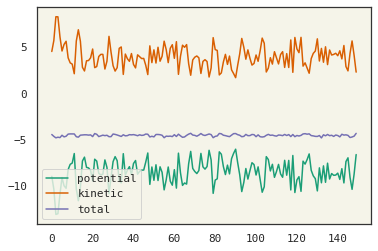

In [8]:
plt.plot(md.pe, label='potential')
plt.plot(md.ke, label='kinetic')
plt.plot(md.te, label='total')
plt.legend(loc='best')

## All Sims

In [9]:
titles = [str(i) for i in range(1,231,14)]
df = pd.DataFrame()
retries = 3
def standardize(te):
    i = int(md.te.shape[0] * 0.2)
    te = md.te[i:]
    return te - np.mean(te)

In [10]:
for i,t in enumerate(titles):    
    md = run_sim(4, 0.2, i+1)
    df = df.assign(**{t: standardize(md.te)})    

{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "sim2d/group-6.dat", "cell_log_file": "sim2d/cell_log_file.dat", "print_period": 300.0, "cell": [2.15444, 0.0, 0.0, 0.0, 2.15444, 0.0, 0.0, 0.0, 2.15444], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "sim2d/group-6.dat", "group": "sim2d/group-6.json"}
Info: You are running version 9075-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-6 with 4 particles and 2 members
Info: Duplicating 4 particles into 4 real particles and 996 ghost for group with 2 elements and 124 tilings. Each cell has 8 particles.
Info: Computed 12 degrees of freedom
        Step         Time            T     

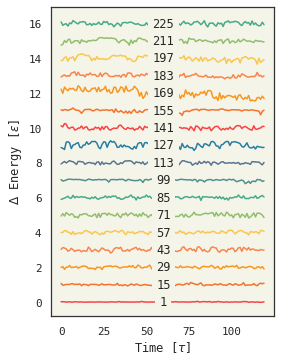

In [11]:
fig = plt.figure(figsize=(4,5.7))
ax = plt.gca()
mx = df.shape[0] // 2
for i,n in enumerate(df.columns):
    color = colors[i % len(base_colors)]
    ax.plot(df[n] + i, color=color)
    offsetbox = mpl.offsetbox.TextArea(n)
    ab = mpl.offsetbox.AnnotationBbox(offsetbox, (mx,i),
                    xybox=(mx,i),
                    xycoords='data',
                    boxcoords='data',
                    arrowprops=None,
                    bboxprops=dict(fc="#f5f4e9", lw=0))
    ax.add_artist(ab)
ax.set_xlabel(r'Time [$\tau$]')
ax.set_facecolor('#f5f4e9')
ax.set_ylabel(r'$\Delta$ Energy [$\epsilon$]')
plt.savefig('energy3d.svg')